<a href="https://colab.research.google.com/github/marinacer/IA048/blob/main/glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/uciml/glass

The dataset is a Glass Identification that contains 214 instances, 9 attributes
*   RI: refractive index

* Na: Sodium

* Mg: Magnesium

* Al: Aluminum

* Si: Silicon

* K: Potassium

* Ca: Calcium

* Ba: Barium

* Fe: Iron

And 6 classes

* 1: building windows float processed

* 2: building windows non float processed

* 3: vehicle windows float processed

* 4: containers

* 5: tableware

* 6: headlamps

In [17]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [18]:
# open the csv file to dataframe
df = pd.read_csv('glass.csv')
df.head()

# atributes to X and labels to y
X = df.drop('Type',axis = 1)
y = df.Type
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [43]:
unique, counts = np.unique(y, return_counts=True)
print("Quantidade de amostras por classe:",counts)
df.groupby('Type').mean()

Quantidade de amostras por classe: [70 76 17 13  9 29]


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
Type,,,,,,,,,
1,1.518718,13.242286,3.552429,1.163857,72.619143,0.447429,8.797286,0.012714,0.057000
2,1.518619,13.111711,3.002105,1.408158,72.598026,0.521053,9.073684,0.050263,0.079737
3,1.517964,13.437059,3.543529,1.201176,72.404706,0.406471,8.782941,0.008824,0.057059
5,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769
6,1.517456,14.646667,1.305556,1.366667,73.206667,0.000000,9.356667,0.000000,0.000000
7,1.517116,14.442069,0.538276,2.122759,72.965862,0.325172,8.491379,1.040000,0.013448


In [19]:
# label encoding. necessário para corrigir um erro do dataset na nomenclatura das classes
label = preprocessing.LabelEncoder()
label.fit(y)
y_label = label.transform(y)

In [26]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_label, test_size = 0.30, random_state = 1)

**Random Forest**

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(Xtrain, ytrain)
y_ran = clf.predict(Xtest)

f1_ran = f1_score(ytest, y_ran, average='macro')
print('F1medida = ', f1_ran)
print('Matriz de confusão')
print(sk.confusion_matrix(ytest,y_ran))
print()

F1medida =  0.7862722245075187
Matriz de confusão
[[22  2  1  0  0  0]
 [ 1 19  0  0  1  0]
 [ 4  1  2  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  1  0]
 [ 0  1  0  0  0  8]]



**KNN**

In [9]:
from sklearn.neighbors import KNeighborsClassifier
F1medida_knn = []
nknn = 3
for i in range(1,nknn):
    neigh = KNeighborsClassifier(n_neighbors = i)
    neigh.fit(Xtrain, ytrain)
    y_pred_knn = neigh.predict(Xtest)

    F1medida_knn.append(f1_score(ytest, y_pred_knn, average='macro'))
    print('F1medida para k = ',i, ': ', F1medida_knn[i-1])
    print('Matriz de confusão para k = ', i)
    print(sk.confusion_matrix(ytest,y_pred_knn))
    print()
#plt.plot(range(1,nknn),F1medida_knn)
#plt.xlabel('Número de vizinhos k');
#plt.ylabel('F1-medida');
#pass

F1medida para k =  1 :  0.7600062539086929
Matriz de confusão para k =  1
[[19  3  3  0  0  0]
 [ 3 17  0  0  1  0]
 [ 5  0  2  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  9]]

F1medida para k =  2 :  0.5184416455702837
Matriz de confusão para k =  2
[[22  3  0  0  0  0]
 [ 4 16  0  0  1  0]
 [ 7  0  0  0  0  0]
 [ 0  1  0  1  0  0]
 [ 0  1  0  0  0  0]
 [ 0  1  0  0  0  8]]



**SVC**

In [10]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(Xtrain, ytrain)
y_svc = clf.predict(Xtest)

f1_svc = f1_score(ytest, y_svc, average='macro')
print('F1medida = ', f1_svc)
print('Matriz de confusão')
print(sk.confusion_matrix(ytest,y_svc))
print()

F1medida =  0.676500143554407
Matriz de confusão
[[22  3  0  0  0  0]
 [ 3 16  0  0  2  0]
 [ 4  3  0  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  9]]



**Logistic Regression**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

reg = LogisticRegression(fit_intercept=True).fit(Xtrain,ytrain)
y_reg = reg.predict(Xtest)


f1_reg = f1_score(ytest, y_reg, average='macro')
print('F1medida = ', f1_reg)
print('Matriz de confusão')
print(sk.confusion_matrix(ytest,y_reg))
print()

F1medida =  0.6440170940170941
Matriz de confusão
[[19  6  0  0  0  0]
 [ 4 15  0  1  1  0]
 [ 4  3  0  0  0  0]
 [ 0  0  0  2  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  9]]



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**K-Means**

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0).fit(Xtrain)
y_kmeans = kmeans.predict(Xtest)

f1_kmeans = f1_score(ytest, y_kmeans, average='macro')
print('F1medida = ', f1_kmeans)
print('Matriz de confusão')
print(sk.confusion_matrix(ytest,y_kmeans))
print()

F1medida =  0.14814814814814814
Matriz de confusão
[[ 8  0  0  0  0 17]
 [ 1  0  0  5  0 15]
 [ 2  0  0  0  0  5]
 [ 0  0  0  2  0  0]
 [ 0  1  0  0  0  0]
 [ 0  8  0  0  1  0]]



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

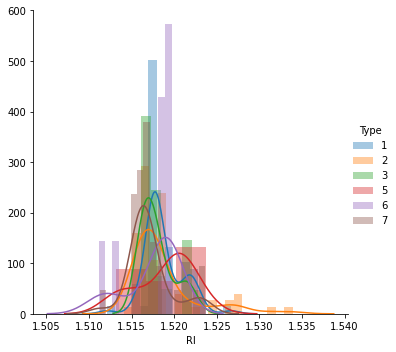

In [30]:
sns.FacetGrid(df,hue="Type",height=5).map(sns.distplot,"RI").add_legend();

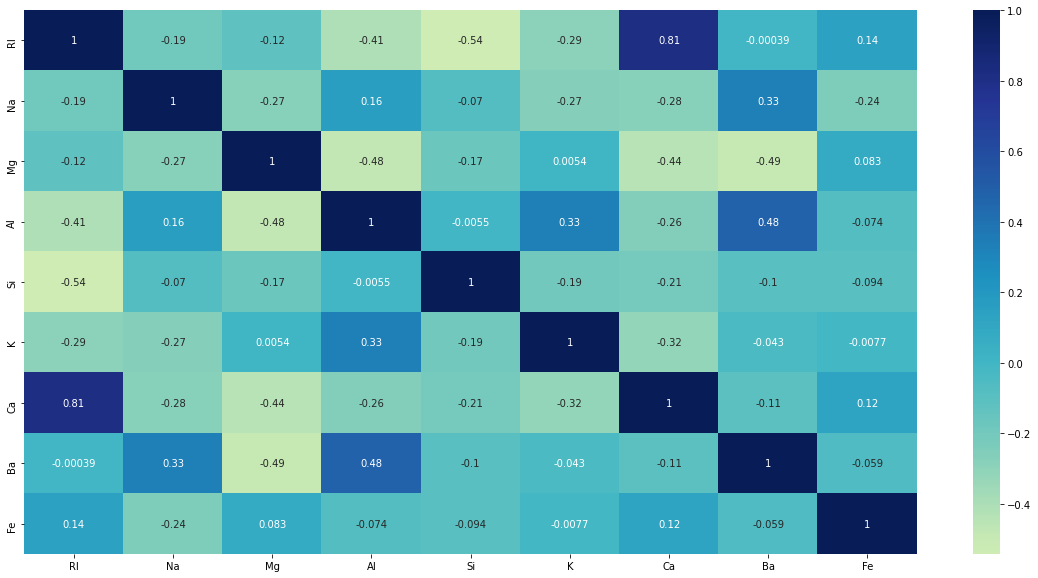

In [16]:
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, ax=ax,cmap="YlGnBu", center = 0)
plt.show()